In [1]:
using Pkg; Pkg.activate("../."); Pkg.instantiate()
using Plots; gr()
using SparseArrays
using Statistics
using ModelingToolkit
using LinearAlgebra
using HDF5
using JLD
using Infiltrator
using Zygote
using PaddedViews
using Flux
using Flux: @epochs
using DiffEqOperators
using Tullio

  Activating environment at `~/Dropbox/Glacier UDE/ODINN_toy/Project.toml`


In [2]:
nx, ny = 100, 100 # Size of the grid
Δx, Δy = 1, 1
Δt = 0.01
t₁ = 1

D₀ = 1
tolnl = 1e-4
itMax = 100
damp = 0.85
dτsc   = 1.0/3.0
ϵ     = 1e-4            # small number
cfl  = max(Δx^2,Δy^2)/4.1

0.24390243902439027

In [3]:
function loss(T, θ, p)
    
    uD = θ[1]
    
    T = heatflow(T, uD, p)

    l_H = sqrt(Flux.Losses.mse(T, T₁; agg=mean))

    return l_H
end

loss (generic function with 1 method)

In [4]:
function heatflow(T, D::Real, p, tol=Inf)
   
    Δx, Δy, Δt, t₁ = p
    
    total_iter = 0
    t = 0
    
    while t < t₁
        
        iter = 1
        err = 2 * tolnl
        Hold = copy(T)
        dTdt = zeros(nx, ny)
        err = Inf 
        
        while iter < itMax+1 && tol <= err
            
            Err = copy(T)
                    
            F, dτ = Heat(T, D, p)
            
            @tullio ResT[i,j] := -(T[i,j] - Hold[i,j])/Δt + F[pad(i-1,1,1),pad(j-1,1,1)] 
            
            dTdt_ = copy(dTdt)
            @tullio dTdt[i,j] := dTdt_[i,j]*damp + ResT[i,j]
            
            T_ = copy(T)
            #@tullio T[i,j] := max(0.0, T_[i,j] + dTdt[i,j]*dτ[pad(i-1,1,1),pad(j-1,1,1)]) 
            @tullio T[i,j] := max(0.0, T_[i,j] + dτ * dTdt[i,j])
            
            Zygote.ignore() do
                Err .= Err .- T
                err = maximum(Err)
            end 
            
            iter += 1
            total_iter += 1
            
        end
        
        t += Δt
        
    end
    
    return T
    
end

heatflow (generic function with 2 methods)

In [5]:
function Heat(T, D, p)
   
    Δx, Δy, Δt, t₁ = p
    
    #dTdx = diff(S, dims=1) / Δx
    #dTdy = diff(S, dims=2) / Δy

    dTdx_edges = diff(T[:,2:end - 1], dims=1) / Δx
    dTdy_edges = diff(T[2:end - 1,:], dims=2) / Δy
    
    Fx = -D * dTdx_edges
    Fy = -D * dTdy_edges    
    F = .-(diff(Fx, dims=1) / Δx .+ diff(Fy, dims=2) / Δy) 

    dτ = dτsc * min( 10.0 , 1.0/(1.0/Δt + 1.0/(cfl/(ϵ + D))))
    
    return F, dτ
 
end

Heat (generic function with 1 method)

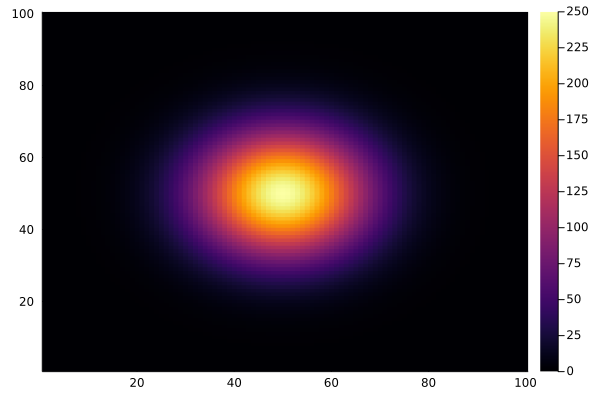

In [6]:
p = (Δx, Δy, Δt, t₁)

T₀ = [ 250 * exp( - ( (i - nx/2)^2 + (j - ny/2)^2 ) / 300 ) for i in 1:nx, j in 1:ny ]

T₁ = copy(T₀)
T₁ = heatflow(T₁, D₀, p, 1e-1)

heatmap(T₀, clim=(0, maximum(T₀)))

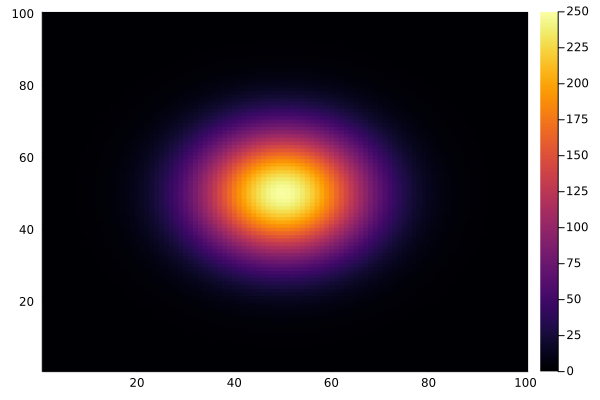

In [7]:
heatmap(T₁, clim=(0, maximum(T₀)))

In [8]:
sqrt( sum((T₁.-T₀).^2) / (nx * ny) )

0.16311579618178718

In [9]:
T = copy(T₀)

loss_uD, back_uD = Zygote.pullback(D -> loss(T, [D], p), 100)

(2.9749888654073713, Zygote.var"#41#42"{typeof(∂(#20))}(∂(#20)))

In [10]:
#all_D = 10 .^ LinRange(-4, 5, 100)
all_D = LinRange(D₀/2, 2D₀, 100)
all_loss = zeros(0)
all_grad = zeros(0)

for d in all_D
    
    T = T₀
    loss_uD, back_uD = Zygote.pullback(D -> loss(T, D, p), d)
    
    println(d)
    println(loss_uD, back_uD(1))
    
    append!(all_loss, loss_uD)
    append!(all_grad, back_uD(1)[1])
end

0.5
0.07979094604952335(-0.16638150528447035,)
0.5151515151515151
0.07732227563096761(-0.16626440503073223,)
0.5303030303030303
0.07485684239885403(-0.16614746884289613,)
0.5454545454545454
0.07239463998834846(-0.1660306963775218,)
0.5606060606060606
0.06993566205130393(-0.16591408729212384,)
0.5757575757575758
0.06747990225621046(-0.1657976412451716,)
0.5909090909090909
0.06502735428811283(-0.16568135789608304,)
0.6060606060606061
0.06257801184858244(-0.165565236905224,)
0.6212121212121212
0.060131868655651996(-0.16544927793390196,)
0.6363636363636364
0.05768891844375638(-0.1653334806443666,)
0.6515151515151515
0.05524915496369331(-0.16521784469980139,)
0.6666666666666666
0.052812571982557045(-0.16510236976432507,)
0.6818181818181819
0.05037916328369812(-0.16498705550298645,)
0.696969696969697
0.047948922666653446(-0.16487190158176096,)
0.7121212121212122
0.04552184394710968(-0.16475690766754678,)
0.7272727272727273
0.0430979209568408(-0.16464207342816436,)
0.7424242424242424
0.040677

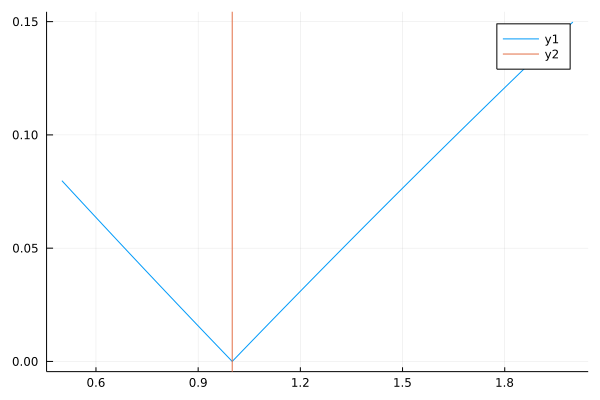

In [11]:
plot(all_D, all_loss)
vline!([D₀])

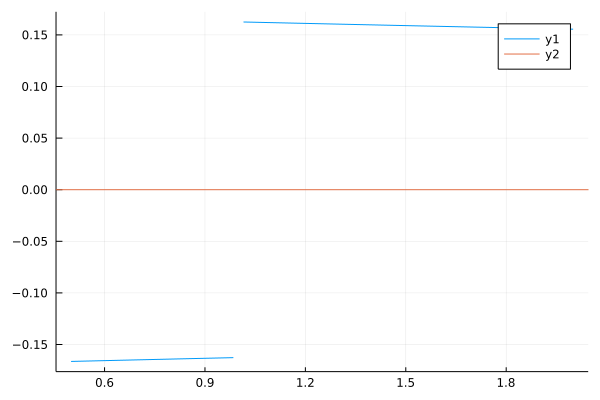

In [12]:
plot(all_D, all_grad)
hline!([0])

### Optimization on D

In [13]:
#Flux.Optimise.update!(opt, x::AbstractMatrix, Δ::AbstractVector) = Flux.Optimise.update!(opt, x, reshape(Δ, size(x)))

In [9]:
function train(loss, p)
    
    θ = [10.]

    opt = ADAM(1.)
    @epochs 100 hybrid_train!(loss, θ, p, opt)
    
    return θ
    
end

function hybrid_train!(loss, θ, p, opt)
        
    T = T₀
    loss_uD, back_uD = Zygote.pullback(θ -> loss(T, θ, p), θ)
    
    ∇_uD = back_uD(one(loss_uD))[1]
    
    println("Current parameter:", θ)
    println("Gradient: ", ∇_uD)
    
    Flux.Optimise.update!(opt, θ, ∇_uD)
    
end

hybrid_train! (generic function with 1 method)

In [15]:
θ₁ = train(loss, p)
D = θ₁[1]

┌ Info: Epoch 1
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current parameter:[10.0]
Gradient: [0.11536990922261617]


┌ Info: Epoch 2
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current parameter:[9.000000086677707]
Gradient: [0.11922079179873475]


┌ Info: Epoch 3
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current parameter:[7.999279243557037]
Gradient: [0.1233400423256745]


┌ Info: Epoch 4
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current parameter:[6.997331176019255]
Gradient: [0.12775896935384992]


┌ Info: Epoch 5
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current parameter:[5.993629080812094]
Gradient: [0.13251400464325394]


┌ Info: Epoch 6
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current parameter:[4.987624425584585]
Gradient: [0.13764779280492606]


┌ Info: Epoch 7
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current parameter:[3.978745514343692]
Gradient: [0.1432105715111693]


┌ Info: Epoch 8
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current parameter:[2.966395809897949]
Gradient: [0.14926193684929934]


┌ Info: Epoch 9
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current parameter:[1.9499519835677606]
Gradient: [0.15587312529575992]


┌ Info: Epoch 10
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current parameter:[0.9287616631417479]
Gradient: [-0.16312999795284797]


┌ Info: Epoch 11
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current parameter:[0.26613894618121636]
Gradient: [-0.16820999339026044]


┌ Info: Epoch 12
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current parameter:[-0.11331803685913006]
Gradient: [-0.1712635510913221]


┌ Info: Epoch 13
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current parameter:[-0.26717248154504303]
Gradient: [-0.17253333447477914]


┌ Info: Epoch 14
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current parameter:[-0.23965863813725788]
Gradient: [-0.17230488372319927]


┌ Info: Epoch 15
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current parameter:[-0.06509240478190528]
Gradient: [-0.17086936069883896]


┌ Info: Epoch 16
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current parameter:[0.2295985998283415]
Gradient: [-0.168499313072393]


┌ Info: Epoch 17
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current parameter:[0.6230209401936011]
Gradient: [-0.16543544532358448]


┌ Info: Epoch 18
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current parameter:[1.0979639314054253]
Gradient: [0.16188142804936623]


┌ Info: Epoch 19
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current parameter:[1.3904338493597104]
Gradient: [0.15976756459129549]


┌ Info: Epoch 20
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current parameter:[1.5275108497713168]
Gradient: [0.1587956389877549]


┌ Info: Epoch 21
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current parameter:[1.5306605756549738]
Gradient: [0.15877344473910315]


┌ Info: Epoch 22
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current parameter:[1.4172133582134638]
Gradient: [0.15957675763678209]


┌ Info: Epoch 23
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current parameter:[1.201350342200053]
Gradient: [0.16112785162873675]


┌ Info: Epoch 24
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current parameter:[0.8947892225635293]
Gradient: [-0.16338300225657554]


┌ Info: Epoch 25
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current parameter:[0.7372458752136477]
Gradient: [-0.16456657332517002]


┌ Info: Epoch 26
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current parameter:[0.7115678116413238]
Gradient: [-0.16476110494338214]


┌ Info: Epoch 27
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current parameter:[0.8021645783445881]
Gradient: [-0.16407679758508129]


┌ Info: Epoch 28
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current parameter:[0.9949431802495554]
Gradient: [-0.16263935647617328]


┌ Info: Epoch 29
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current parameter:[1.2772211971475034]
Gradient: [0.16057926592752128]


┌ Info: Epoch 30
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current parameter:[1.4215811503404931]
Gradient: [0.15954567969651087]


┌ Info: Epoch 31
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current parameter:[1.4440495511123914]
Gradient: [0.15938600176612314]


┌ Info: Epoch 32
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current parameter:[1.3581018953337425]
Gradient: [0.15999853995760369]


┌ Info: Epoch 33
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current parameter:[1.175143134790285]
Gradient: [0.16131821205831476]


┌ Info: Epoch 34
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current parameter:[0.9048655142588982]
Gradient: [-0.1633078791775321]


┌ Info: Epoch 35
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current parameter:[0.7698984501982187]
Gradient: [-0.16431986416893632]


┌ Info: Epoch 36
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current parameter:[0.7563390606453874]
Gradient: [-0.1644222237129232]


┌ Info: Epoch 37
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current parameter:[0.8512176434783165]
Gradient: [-0.16370864118265577]


┌ Info: Epoch 38
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current parameter:[1.0425125932399535]
Gradient: [0.16228850940048029]


┌ Info: Epoch 39
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current parameter:[1.1092039358601196]
Gradient: [0.1617991603916198]


┌ Info: Epoch 40
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current parameter:[1.0646861868342596]
Gradient: [0.1621254833426439]


┌ Info: Epoch 41
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current parameter:[0.9203731013582137]
Gradient: [-0.16319239782043252]


┌ Info: Epoch 42
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current parameter:[0.8955806650769476]
Gradient: [-0.1633770992215826]


┌ Info: Epoch 43
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current parameter:[0.9779842565131833]
Gradient: [-0.16276480230265067]


┌ Info: Epoch 44
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current parameter:[1.1560768180100316]
Gradient: [0.16145698526133795]


┌ Info: Epoch 45
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current parameter:[1.2130328153172574]
Gradient: [0.1610431381845939]


┌ Info: Epoch 46
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current parameter:[1.1615560672037903]
Gradient: [0.1614170804792927]


┌ Info: Epoch 47
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current parameter:[1.0125212605226777]
Gradient: [0.16250953386845374]


┌ Info: Epoch 48
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current parameter:[0.7752537137992866]
Gradient: [-0.16427947235994883]


┌ Info: Epoch 49
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current parameter:[0.6663241410103358]
Gradient: [-0.16510497849441982]


┌ Info: Epoch 50
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current parameter:[0.67308889681372]
Gradient: [-0.1650534722332006]


┌ Info: Epoch 51
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current parameter:[0.7836400361252794]
Gradient: [-0.1642162586687482]


┌ Info: Epoch 52
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current parameter:[0.9868308424821073]
Gradient: [-0.16269933971584963]


┌ Info: Epoch 53
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current parameter:[1.272290431504607]
Gradient: [0.16061480483087837]


┌ Info: Epoch 54
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current parameter:[1.4276648687518105]
Gradient: [0.15950241260107292]


┌ Info: Epoch 55
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current parameter:[1.466806420011293]
Gradient: [0.1592245980258941]


┌ Info: Epoch 56
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current parameter:[1.4015979458542707]
Gradient: [0.15968796394454693]


┌ Info: Epoch 57
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current parameter:[1.2422555646745965]
Gradient: [0.16083162255883152]


┌ Info: Epoch 58
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current parameter:[0.9975662585216281]
Gradient: [-0.16261997066217562]


┌ Info: Epoch 59
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current parameter:[0.8798985117854837]
Gradient: [-0.16349414503185586]


┌ Info: Epoch 60
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current parameter:[0.8769605840244076]
Gradient: [-0.16351609122434893]


┌ Info: Epoch 61
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current parameter:[0.9771515954478919]
Gradient: [-0.16277096649438352]


┌ Info: Epoch 62
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current parameter:[1.1695819873014481]
Gradient: [0.16135866402777282]


┌ Info: Epoch 63
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current parameter:[1.2413220622236218]
Gradient: [0.16083837073424434]


┌ Info: Epoch 64
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current parameter:[1.2048429681317057]
Gradient: [0.16110251614981638]


┌ Info: Epoch 65
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current parameter:[1.070860346248667]
Gradient: [0.16208014736800894]


┌ Info: Epoch 66
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current parameter:[0.8485858776682966]
Gradient: [-0.16372835150531262]


┌ Info: Epoch 67
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current parameter:[0.7513610695561835]
Gradient: [-0.16445983434774003]


┌ Info: Epoch 68
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current parameter:[0.7670251889519999]
Gradient: [-0.1643415437553235]


┌ Info: Epoch 69
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current parameter:[0.8841012717047189]
Gradient: [-0.1634627607979795]


┌ Info: Epoch 70
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current parameter:[1.0918147534959244]
Gradient: [0.16192647029108043]


┌ Info: Epoch 71
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current parameter:[1.1773051676881825]
Gradient: [0.16130249081423118]


┌ Info: Epoch 72
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current parameter:[1.1532412074754412]
Gradient: [0.16147764442677634]


┌ Info: Epoch 73
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current parameter:[1.0305095738540242]
Gradient: [0.1623768950660243]


┌ Info: Epoch 74
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current parameter:[0.8184686608651965]
Gradient: [-0.16395424820376484]


┌ Info: Epoch 75
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current parameter:[0.7302680857267649]
Gradient: [-0.16461939030219447]


┌ Info: Epoch 76
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current parameter:[0.7538513733223519]
Gradient: [-0.1644410170040163]


┌ Info: Epoch 77
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current parameter:[0.8778404143513481]
Gradient: [-0.1635095183144951]


┌ Info: Epoch 78
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current parameter:[1.0915514593012179]
Gradient: [0.16192839945770596]


┌ Info: Epoch 79
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current parameter:[1.1827051867453968]
Gradient: [0.16126323785176172]


┌ Info: Epoch 80
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current parameter:[1.164010198414742]
Gradient: [0.16139921367697993]


┌ Info: Epoch 81
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current parameter:[1.0463912127702888]
Gradient: [0.16225996921064278]


┌ Info: Epoch 82
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current parameter:[0.8392405898895582]
Gradient: [-0.16379838023568466]


┌ Info: Epoch 83
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current parameter:[0.7551053921065225]
Gradient: [-0.16443154295541207]


┌ Info: Epoch 84
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current parameter:[0.7820122588085133]
Gradient: [-0.16422852459663312]


┌ Info: Epoch 85
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current parameter:[0.9086626333723965]
Gradient: [-0.16327958787449032]


┌ Info: Epoch 86
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current parameter:[1.1244459829073126]
Gradient: [0.16168773402573197]


┌ Info: Epoch 87
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current parameter:[1.217807658288058]
Gradient: [0.1610085397740044]


┌ Info: Epoch 88
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current parameter:[1.201436185979558]
Gradient: [0.1611272288235255]


┌ Info: Epoch 89
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current parameter:[1.086243197396882]
Gradient: [0.1619673030660796]


┌ Info: Epoch 90
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current parameter:[0.8816115519256734]
Gradient: [-0.16348135140474557]


┌ Info: Epoch 91
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current parameter:[0.7993768410235239]
Gradient: [-0.1640977698406081]


┌ Info: Epoch 92
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current parameter:[0.8276331989937364]
Gradient: [-0.16388544312272707]


┌ Info: Epoch 93
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current parameter:[0.9551473976975127]
Gradient: [-0.16293403233852422]


┌ Info: Epoch 94
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current parameter:[1.1713694362423281]
Gradient: [0.16134565986158753]


┌ Info: Epoch 95
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current parameter:[1.265473570736242]
Gradient: [0.1606639637398202]


┌ Info: Epoch 96
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current parameter:[1.2501079222739695]
Gradient: [0.1607748811458873]


┌ Info: Epoch 97
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current parameter:[1.1361533691217947]
Gradient: [0.161602251418249]


┌ Info: Epoch 98
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current parameter:[0.9329681514708055]
Gradient: [-0.16309872510376058]


┌ Info: Epoch 99
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current parameter:[0.8516809597891926]
Gradient: [-0.1637051717150996]


┌ Info: Epoch 100
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current parameter:[0.8804420853535252]
Gradient: [-0.16349008520426256]


1.0080732395002612

In [16]:
D

1.0080732395002612

## Example with NN

Let's assume that $D$ is a function of time

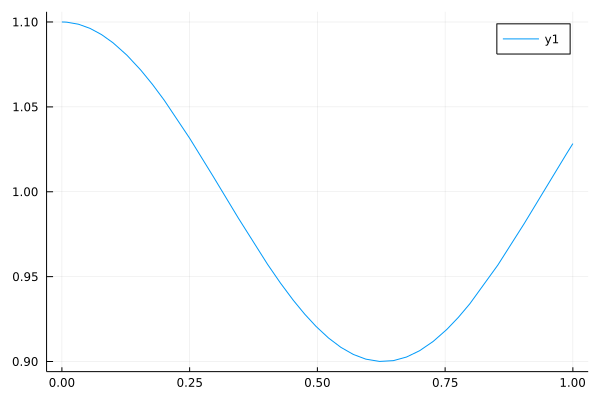

In [10]:
fakeD(t) = D₀ * (1 + 0.1 * cos(5t) )

plot(fakeD, 0, t₁)

In [11]:
function heatflow(T, fD::Function, p, tol=Inf)
   
    Δx, Δy, Δt, t₁ = p
    
    total_iter = 0
    t = 0
    
    while t < t₁
        
        iter = 1
        err = 2 * tolnl
        Hold = copy(T)
        dTdt = zeros(nx, ny)
        err = Inf 
        
        while iter < itMax+1 && tol <= err
            
            Err = copy(T)
                    
            D = fD(t)  # compute the diffusivity at each time
            F, dτ = Heat(T, D, p)
            
            @tullio ResT[i,j] := -(T[i,j] - Hold[i,j])/Δt + F[pad(i-1,1,1),pad(j-1,1,1)] 
            
            dTdt_ = copy(dTdt)
            @tullio dTdt[i,j] := dTdt_[i,j]*damp + ResT[i,j]
            
            T_ = copy(T)
            #@tullio T[i,j] := max(0.0, T_[i,j] + dTdt[i,j]*dτ[pad(i-1,1,1),pad(j-1,1,1)]) 
            @tullio T[i,j] := max(0.0, T_[i,j] + dτ * dTdt[i,j])
            
            Zygote.ignore() do
                Err .= Err .- T
                err = maximum(Err)
            end 
            
            iter += 1
            total_iter += 1
            
        end
        
        t += Δt
        
    end
    
    return T
    
end

heatflow (generic function with 4 methods)

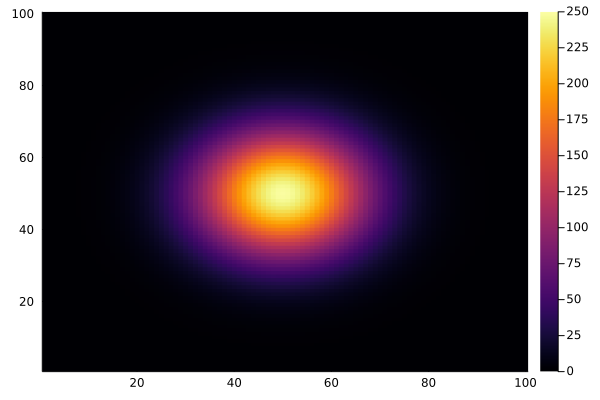

In [12]:
p = (Δx, Δy, Δt, t₁)

T₂ = copy(T₀)
T₂ = heatflow(T₂, fakeD, p, 1e-1)

heatmap(T₂, clim=(0, maximum(T₀)))

In [13]:
sqrt( sum((T₂.-T₀).^2) / (nx * ny) )

0.16014718009460116

Now, let's try to reproduce `fakeD()` with a NN.

In [61]:
function heatflow_NN(T, uD, p, tol=Inf)
   
    Δx, Δy, Δt, t₁ = p
    
    total_iter = 0
    t = 0
    
    while t < t₁
        
        iter = 1
        err = 2 * tolnl
        Hold = copy(T)
        dTdt = zeros(nx, ny)
        err = Inf 
        
        while iter < itMax+1 && tol <= err
            
            Err = copy(T)
                    
            D = uD([t]')[1]  # compute the diffusivity at each time
            F, dτ = Heat(T, D, p)
            
            @tullio ResT[i,j] := -(T[i,j] - Hold[i,j])/Δt + F[pad(i-1,1,1),pad(j-1,1,1)] 
            
            dTdt_ = copy(dTdt)
            @tullio dTdt[i,j] := dTdt_[i,j]*damp + ResT[i,j]
            
            T_ = copy(T)
            #@tullio T[i,j] := max(0.0, T_[i,j] + dTdt[i,j]*dτ[pad(i-1,1,1),pad(j-1,1,1)]) 
            @tullio T[i,j] := max(0.0, T_[i,j] + dτ * dTdt[i,j])
            
            Zygote.ignore() do
                Err .= Err .- T
                err = maximum(Err)
            end 
            
            iter += 1
            total_iter += 1
            
        end
        
        t += Δt
        
    end
    
    return T
    
end

heatflow_NN (generic function with 2 methods)

In [62]:
function loss_NN(T, UD, p)

    T = heatflow_NN(T, UD, p)
    l_H = sqrt(Flux.Losses.mse(T, T₂; agg=mean))

    return l_H
end

loss_NN (generic function with 1 method)

In [63]:
Flux.Optimise.update!(opt, x::AbstractMatrix, Δ::AbstractVector) = Flux.Optimise.update!(opt, x, reshape(Δ, size(x)))

function train(loss, p)
    
    leakyrelu(x, a=0.01) = max(a*x, x)
    relu(x) = max(0, x)

    UD = Chain(
        Dense(1,10,initb = Flux.zeros), 
        BatchNorm(10, leakyrelu),
        Dense(10,5,initb = Flux.zeros), 
        BatchNorm(5, leakyrelu),
        Dense(5,1, relu, initb = Flux.zeros) 
    )
    
    opt = ADAM(1.)
    @epochs 2 hybrid_train_NN!(loss, UD, p, opt)
    
    return θ
    
end

function hybrid_train_NN!(loss, UD, p, opt)
        
    T = T₀
    θ = params(UD)
    loss_uD, back_uD = Zygote.pullback(() -> loss(T, UD, p), θ)
    
    ∇_uD = back_uD(one(loss_uD))[1]
    
    println("Current parameter:", θ)
    println("Gradient: ", ∇_uD)
    
    Flux.Optimise.update!(opt, θ, ∇_uD)
    
end

hybrid_train_NN! (generic function with 1 method)

In [64]:
train(loss_NN, p)

┌ Info: Epoch 1
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


LoadError: Only reference types can be differentiated with `Params`.